In [48]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import *
from helper import collate_fn, draw_box

In [98]:
import torchvision.transforms.functional as TF

crop = torchvision.transforms.CenterCrop(256)

class PretrainingDataset(UnlabeledDataset):
    def __getitem__(self, index):
        scene_id = self.scene_index[index // (NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE)]
        sample_id = (index % (NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE)) // NUM_IMAGE_PER_SAMPLE
        image_name = image_names[index % NUM_IMAGE_PER_SAMPLE]

        image_path = os.path.join(self.image_folder, f'scene_{scene_id}', f'sample_{sample_id}', image_name) 
        
        image = Image.open(image_path)
        y = random.randint(0, 3)
        image = crop(image)
        image = TF.rotate(image, y*90)

        return self.transform(image), y

In [99]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [100]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

In [101]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [116]:
# get image

unlabeled_trainset = PretrainingDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='image', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=8, shuffle=True, num_workers=0)

In [117]:
# [batch_size, 3, H, W]
image, y = iter(trainloader).next()
print(image.shape, y)

torch.Size([8, 3, 256, 256]) tensor([3, 3, 2, 0, 0, 0, 3, 0])


(-0.5, 255.5, 255.5, -0.5)

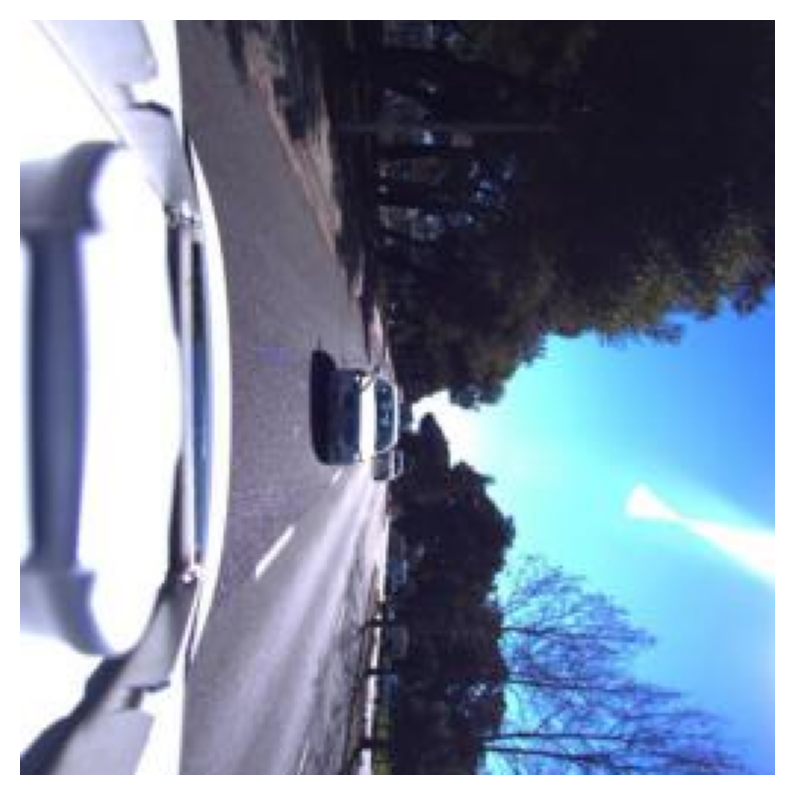

In [106]:
plt.imshow(image[0].numpy().transpose(1, 2, 0))
plt.axis('off')

In [119]:
class FeatureSelector(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7, stride=3)
        self.conv2 = nn.Conv2d(6, 16, 6, stride=3)
        self.conv3 = nn.Conv2d(16, 24, 5, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class Classifier(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(24 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)
 
    def forward(self, x):
        x = x.view(-1, 24 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.featureselector = FeatureSelector()
        self.classifier = Classifier()
 
    def forward(self, x):
        x = self.featureselector(x)
        x = self.classifier(x)
        return x

In [120]:
import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [121]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.069
[1,   200] loss: 0.068
[1,   300] loss: 0.039
[1,   400] loss: 0.020
[1,   500] loss: 0.016
[1,   600] loss: 0.016
[1,   700] loss: 0.009


KeyboardInterrupt: 

In [ ]:
# TO DO:
# 1. validation set between epochs
# 2. track accuracy in addition to loss 